# 图像分类

[CIFAR-10 数据集](https://www.cs.toronto.edu/~kriz/cifar.html) 中的图片进行分类。该数据集包含飞机、猫狗和其他物体。需要预处理这些图片，然后用所有样本训练一个卷积神经网络。图片需要标准化（normalized），标签需要采用 one-hot 编码。然后要构建模型：卷积层、最大池化（max pooling）、丢弃（dropout）和完全连接（fully connected）的层。最后，你需要在样本图片进行神经网络的预测。


## 获取数据

数据集下载地址[CIFAR-10 数据集（Python版）](https://www.cs.toronto.edu/~kriz/cifar-10-python.tar.gz)。


## 探索数据

该数据集分成了几部分／批次（batches），以免你的机器在计算时内存不足。CIFAR-10 数据集包含 5 个部分，名称分别为 `data_batch_1`、`data_batch_2`，以此类推。每个部分都包含以下某个类别的标签和图片：

* 飞机
* 汽车
* 鸟类
* 猫
* 鹿
* 狗
* 青蛙
* 马
* 船只
* 卡车

了解数据集也是对数据进行预测的必经步骤。通过更改 `batch_id` 和 `sample_id` 探索下面的代码单元。`batch_id` 是数据集一个部分的 ID（1 到 5）。`sample_id` 是该部分中图片和标签对（label pair）的 ID。




Stats of batch 2:
Samples: 10000
Label Counts: {0: 984, 1: 1007, 2: 1010, 3: 995, 4: 1010, 5: 988, 6: 1008, 7: 1026, 8: 987, 9: 985}
First 20 Labels: [1, 6, 6, 8, 8, 3, 4, 6, 0, 6, 0, 3, 6, 6, 5, 4, 8, 3, 2, 6]

Example of Image 20:
Image - Min Value: 24 Max Value: 206
Image - Shape: (32, 32, 3)
Label - Label Id: 0 Name: airplane


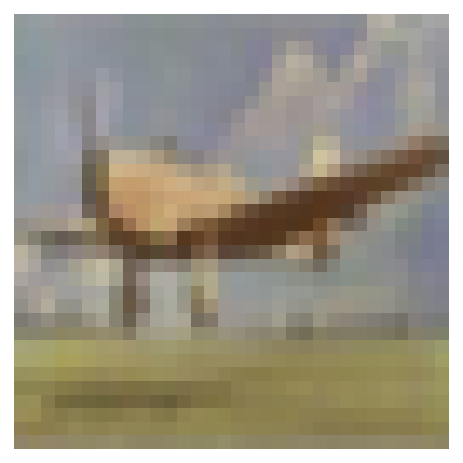

In [1]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

import helper
import numpy as np
cifar10_dataset_folder_path = './cifar-10-python/cifar-10-batches-py'

# 探索数据集
batch_id = 2
sample_id = 20
helper.display_stats(cifar10_dataset_folder_path, batch_id, sample_id)

## 实现预处理函数

### 标准化

在下面的单元中，实现 `normalize` 函数，传入图片数据 `x`，并返回标准化 Numpy 数组。值应该在 0 到 1 的范围内（含 0 和 1）。返回对象应该和 `x` 的形状一样。


In [2]:
def normalize(x):
    """
    归一化处理图片数据，将其缩放到（0,1）
    : x: 图片数据.  图片的shape= (32, 32, 3)
    : return: 归一化的numpy数组
    """
    # 需要编程: 部署函数
    result=0+(x-x.min())*1.0/(x.max()-x.min())
    return result

### One-hot 编码

需要实现 `one_hot_encode` 函数。输入，也就是 `x`，是一个标签列表。实现该函数，以返回为 one_hot 编码的 Numpy 数组的标签列表。标签的可能值为 0 到 9。每次调用 `one_hot_encode` 时，对于每个值，one_hot 编码函数应该返回相同的编码。





In [3]:
def one_hot_encode(x):
    """
    : x: 样品标签
    : return: 独热编码标签 是一个numpy 数组
    """
    # 需要编程: 部署函数4,0001000000
    encode=[]
    for value in x:
        list=np.zeros([10])
        list[value]=1
        encode.append(list)
    return np.array(encode)

### 随机化数据

数据存储上和mnist一样是随机存放的，所以不需要打乱。

## 预处理所有数据并保存

运行下方的代码单元，将预处理所有 CIFAR-10 数据，并保存到文件中。下面的代码还使用了 10% 的训练数据，用来验证。


In [7]:
# 预处理训练数据集，验证数据集，测试数据集
helper.preprocess_and_save_data(cifar10_dataset_folder_path, normalize, one_hot_encode)

# 检查点

这是第一个检查点。重新启动记事本后，可以从这里开始。因为预处理的数据已保存到本地。


In [6]:
import pickle
import helper
# 读取已经保存的验证数据集 
valid_features, valid_labels = pickle.load(open('preprocess_validation.p', mode='rb'))
valid_features.shape

(5000, 32, 32, 3)

### 超参数

调试以下超参数：
* 设置 `epochs` 表示神经网络停止学习或开始过拟合的迭代次数
* 设置 `batch_size`，表示机器内存允许的部分最大体积。大部分人设为以下常见内存大小：

 * 64
 * 128
 * 256
 * ...
* 设置 `learning_rate` 表示学习率

In [46]:
# 需要设置: 调整设置超参数
epochs = 200
batch_size = 1024#和计算机显存大小相关，OOM（out of memory）当batch_size增大时，每个epoch内参数更新的次数就变少了，
#所以epoch也要增大。对于不同网络，不同数据，要好好调的一个重要参数
learning_rate = 0.01

### 创建卷积模型

创建卷积神经网络模型。该函数传入一批图片 `x`，并输出对数（logits）。使用我们在上面创建的层创建模型：

* 创建 1、2 或 3 个卷积和最大池化层（Convolution and Max Pool layers）
* 创建一个扁平层（Flatten Layer）
* 创建 1、2 或 3 个完全连接层（Fully Connected Layers）
* 创建一个输出层（Output Layer）
* 返回输出


In [51]:
import tensorflow as tf


##############################
## Build the Neural Network ##
##############################


tf.reset_default_graph()
#第一步可以调整的就是网络结构的参数
# 输入
inputs = tf.placeholder(tf.float32,[None,32,32,3],name='inputs')
labels = tf.placeholder(tf.float32,[None,10],name='labels')

conv1_1=tf.layers.conv2d(inputs,32,(3,3),padding='SAME',activation=tf.nn.relu,#3*3*3*32+32
                       kernel_initializer=tf.truncated_normal_initializer(stddev=0.1))
conv1_2=tf.layers.conv2d(conv1_1,32,(3,3),padding='SAME',activation=tf.nn.relu,#3*3*32*32+32
                       kernel_initializer=tf.truncated_normal_initializer(stddev=0.1))
pool1=tf.layers.max_pooling2d(conv1_2,(2,2),(2,2))
conv2=tf.layers.conv2d(pool1,64,(3,3),padding='SAME',activation=tf.nn.relu,
                       kernel_initializer=tf.truncated_normal_initializer(stddev=0.1))
pool2=tf.layers.max_pooling2d(conv2,(2,2),(2,2))
conv3=tf.layers.conv2d(pool2,128,(3,3),padding='SAME',activation=tf.nn.relu,
                       kernel_initializer=tf.truncated_normal_initializer(stddev=0.1))
pool3=tf.layers.max_pooling2d(conv3,(2,2),(2,2))

flatten=tf.layers.flatten(pool3)
fc1=tf.layers.dense(flatten,100,activation=tf.nn.relu)
fc2=tf.layers.dense(fc1,100,activation=tf.nn.relu)#100*50*50=5050


logits=tf.layers.dense(fc2,10)

# 模型

# 命名 logits Tensor, 以便后面调用
logits = tf.identity(logits, name='logits')

cost = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits=logits, labels=labels))
#optimizer = tf.train.GradientDescentOptimizer(learning_rate).minimize(cost)
optimizer = tf.train.AdamOptimizer().minimize(cost)

correct_pred = tf.equal(tf.argmax(logits, 1), tf.argmax(labels, 1))
accuracy = tf.reduce_mean(tf.cast(correct_pred, tf.float32), name='accuracy')

### 超参数

调试以下超参数：
* 设置 `epochs` 表示神经网络停止学习或开始过拟合的迭代次数
* 设置 `batch_size`，表示机器内存允许的部分最大体积。大部分人设为以下常见内存大小：

 * 64
 * 128
 * 256
 * ...
* 设置 `learning_rate` 表示学习率

### 在单个 CIFAR-10 部分上训练

我们先用单个部分的 CIFAR-10 批次训练神经网络。这样可以节省时间，并对模型进行迭代，以提高准确率。最终验证准确率达到 50% 或以上之后，在下一部分对所有数据运行模型。

In [50]:
print('在单个批量数据上训练...')
config=tf.ConfigProto()
config.gpu_options.allow_growth=True
with tf.Session(config=config) as sess:
    # 初始化变量
    sess.run(tf.global_variables_initializer())
    
    # 训练过程
    for epoch in range(epochs):
        batch_i = 1
        #mnist.train.next_batch(batchsize)
        for batch_features, batch_labels in helper.load_preprocess_training_batch(batch_i, batch_size):
            sess.run(optimizer,feed_dict={inputs:batch_features,
                                     labels:batch_labels})
        print('Epoch {:>2}, CIFAR-10 Batch {}:  '.format(epoch + 1, batch_i), end='')
        #print_stats(sess, batch_features, batch_labels, cost, accuracy)
        loss=sess.run(cost,feed_dict={inputs:batch_features,
                                     labels:batch_labels})
        valid_cc=sess.run(accuracy,feed_dict={inputs:valid_features[:],
                                             labels:valid_labels[:]})
        print('Loss: {:>10.4f} Validation Accuracy: {:.6f}'.
          format(loss,valid_cc))

在单个批量数据上训练...
Epoch  1, CIFAR-10 Batch 1:  Loss:  2048.4946 Validation Accuracy: 0.100600
Epoch  2, CIFAR-10 Batch 1:  Loss:   924.3092 Validation Accuracy: 0.125800
Epoch  3, CIFAR-10 Batch 1:  Loss:   338.3895 Validation Accuracy: 0.141600
Epoch  4, CIFAR-10 Batch 1:  Loss:   235.3598 Validation Accuracy: 0.141800
Epoch  5, CIFAR-10 Batch 1:  Loss:   173.8764 Validation Accuracy: 0.200000
Epoch  6, CIFAR-10 Batch 1:  Loss:   136.3488 Validation Accuracy: 0.211400
Epoch  7, CIFAR-10 Batch 1:  Loss:   113.7296 Validation Accuracy: 0.217800
Epoch  8, CIFAR-10 Batch 1:  Loss:    96.7517 Validation Accuracy: 0.230000
Epoch  9, CIFAR-10 Batch 1:  Loss:    88.0628 Validation Accuracy: 0.225000
Epoch 10, CIFAR-10 Batch 1:  Loss:    82.2262 Validation Accuracy: 0.227800
Epoch 11, CIFAR-10 Batch 1:  Loss:    75.4291 Validation Accuracy: 0.238000
Epoch 12, CIFAR-10 Batch 1:  Loss:    69.6343 Validation Accuracy: 0.237600
Epoch 13, CIFAR-10 Batch 1:  Loss:    64.3277 Validation Accuracy: 0.24780

KeyboardInterrupt: 

### 完全训练模型

现在，单个 CIFAR-10 部分的准确率已经不错了，试试所有五个部分吧。

In [52]:

save_model_path = './image_classification'

print('训练...')
with tf.Session() as sess:
 
    sess.run(tf.global_variables_initializer())
    
    # 训练过程
    for epoch in range(epochs):
        # 遍历所有batch
        n_batches = 5
        for batch_i in range(1, n_batches + 1):
            for batch_features, batch_labels in helper.load_preprocess_training_batch(batch_i, batch_size):
                 sess.run(optimizer,feed_dict={inputs:batch_features,
                                     labels:batch_labels})
            print('Epoch {:>2}, CIFAR-10 Batch {}:  '.format(epoch + 1, batch_i), end='')
            loss=sess.run(cost,feed_dict={inputs:batch_features,
                                     labels:batch_labels})
            valid_cc=sess.run(accuracy,feed_dict={inputs:valid_features[:],
                                                 labels:valid_labels[:]})
            print('Loss: {:>10.4f} Validation Accuracy: {:.6f}'.
              format(loss,valid_cc))
            
    # 保存模型
    saver = tf.train.Saver()
    save_path = saver.save(sess, save_model_path)

训练...
Epoch  1, CIFAR-10 Batch 1:  Loss:     2.1579 Validation Accuracy: 0.187600
Epoch  1, CIFAR-10 Batch 2:  Loss:     1.9327 Validation Accuracy: 0.299800
Epoch  1, CIFAR-10 Batch 3:  Loss:     1.7673 Validation Accuracy: 0.351400
Epoch  1, CIFAR-10 Batch 4:  Loss:     1.6952 Validation Accuracy: 0.376400
Epoch  1, CIFAR-10 Batch 5:  Loss:     1.5966 Validation Accuracy: 0.417000
Epoch  2, CIFAR-10 Batch 1:  Loss:     1.5660 Validation Accuracy: 0.427200
Epoch  2, CIFAR-10 Batch 2:  Loss:     1.5416 Validation Accuracy: 0.442000
Epoch  2, CIFAR-10 Batch 3:  Loss:     1.4113 Validation Accuracy: 0.452000
Epoch  2, CIFAR-10 Batch 4:  Loss:     1.4045 Validation Accuracy: 0.473400
Epoch  2, CIFAR-10 Batch 5:  Loss:     1.3911 Validation Accuracy: 0.485800
Epoch  3, CIFAR-10 Batch 1:  Loss:     1.3459 Validation Accuracy: 0.505800
Epoch  3, CIFAR-10 Batch 2:  Loss:     1.3563 Validation Accuracy: 0.520200
Epoch  3, CIFAR-10 Batch 3:  Loss:     1.3110 Validation Accuracy: 0.499600
Epoch 

Epoch 22, CIFAR-10 Batch 4:  Loss:     0.4554 Validation Accuracy: 0.704200
Epoch 22, CIFAR-10 Batch 5:  Loss:     0.5195 Validation Accuracy: 0.692400
Epoch 23, CIFAR-10 Batch 1:  Loss:     0.4762 Validation Accuracy: 0.698400
Epoch 23, CIFAR-10 Batch 2:  Loss:     0.4988 Validation Accuracy: 0.710200
Epoch 23, CIFAR-10 Batch 3:  Loss:     0.4707 Validation Accuracy: 0.716400
Epoch 23, CIFAR-10 Batch 4:  Loss:     0.4652 Validation Accuracy: 0.698200
Epoch 23, CIFAR-10 Batch 5:  Loss:     0.4793 Validation Accuracy: 0.695600
Epoch 24, CIFAR-10 Batch 1:  Loss:     0.4451 Validation Accuracy: 0.701800
Epoch 24, CIFAR-10 Batch 2:  Loss:     0.4801 Validation Accuracy: 0.705800
Epoch 24, CIFAR-10 Batch 3:  Loss:     0.4611 Validation Accuracy: 0.708600
Epoch 24, CIFAR-10 Batch 4:  Loss:     0.4339 Validation Accuracy: 0.700800
Epoch 24, CIFAR-10 Batch 5:  Loss:     0.4658 Validation Accuracy: 0.696600
Epoch 25, CIFAR-10 Batch 1:  Loss:     0.4373 Validation Accuracy: 0.704600
Epoch 25, CI

Epoch 44, CIFAR-10 Batch 2:  Loss:     0.2089 Validation Accuracy: 0.716600
Epoch 44, CIFAR-10 Batch 3:  Loss:     0.2207 Validation Accuracy: 0.699000
Epoch 44, CIFAR-10 Batch 4:  Loss:     0.2073 Validation Accuracy: 0.695200
Epoch 44, CIFAR-10 Batch 5:  Loss:     0.2053 Validation Accuracy: 0.691000
Epoch 45, CIFAR-10 Batch 1:  Loss:     0.2056 Validation Accuracy: 0.703400
Epoch 45, CIFAR-10 Batch 2:  Loss:     0.1938 Validation Accuracy: 0.719800
Epoch 45, CIFAR-10 Batch 3:  Loss:     0.1966 Validation Accuracy: 0.706000
Epoch 45, CIFAR-10 Batch 4:  Loss:     0.2484 Validation Accuracy: 0.677800
Epoch 45, CIFAR-10 Batch 5:  Loss:     0.2396 Validation Accuracy: 0.679200
Epoch 46, CIFAR-10 Batch 1:  Loss:     0.2290 Validation Accuracy: 0.690000
Epoch 46, CIFAR-10 Batch 2:  Loss:     0.2520 Validation Accuracy: 0.695000
Epoch 46, CIFAR-10 Batch 3:  Loss:     0.2138 Validation Accuracy: 0.700400
Epoch 46, CIFAR-10 Batch 4:  Loss:     0.1593 Validation Accuracy: 0.698800
Epoch 46, CI

Epoch 65, CIFAR-10 Batch 5:  Loss:     0.0921 Validation Accuracy: 0.695200
Epoch 66, CIFAR-10 Batch 1:  Loss:     0.1597 Validation Accuracy: 0.682200
Epoch 66, CIFAR-10 Batch 2:  Loss:     0.1176 Validation Accuracy: 0.688000
Epoch 66, CIFAR-10 Batch 3:  Loss:     0.1316 Validation Accuracy: 0.686600
Epoch 66, CIFAR-10 Batch 4:  Loss:     0.0848 Validation Accuracy: 0.689000
Epoch 66, CIFAR-10 Batch 5:  Loss:     0.1233 Validation Accuracy: 0.692800
Epoch 67, CIFAR-10 Batch 1:  Loss:     0.1120 Validation Accuracy: 0.690400
Epoch 67, CIFAR-10 Batch 2:  Loss:     0.0946 Validation Accuracy: 0.700600
Epoch 67, CIFAR-10 Batch 3:  Loss:     0.1216 Validation Accuracy: 0.687000
Epoch 67, CIFAR-10 Batch 4:  Loss:     0.1048 Validation Accuracy: 0.687600
Epoch 67, CIFAR-10 Batch 5:  Loss:     0.1343 Validation Accuracy: 0.670600
Epoch 68, CIFAR-10 Batch 1:  Loss:     0.1088 Validation Accuracy: 0.692000
Epoch 68, CIFAR-10 Batch 2:  Loss:     0.1186 Validation Accuracy: 0.684000
Epoch 68, CI

Epoch 87, CIFAR-10 Batch 3:  Loss:     0.0412 Validation Accuracy: 0.694200
Epoch 87, CIFAR-10 Batch 4:  Loss:     0.0815 Validation Accuracy: 0.674200
Epoch 87, CIFAR-10 Batch 5:  Loss:     0.0566 Validation Accuracy: 0.684000
Epoch 88, CIFAR-10 Batch 1:  Loss:     0.0347 Validation Accuracy: 0.696200
Epoch 88, CIFAR-10 Batch 2:  Loss:     0.0251 Validation Accuracy: 0.692400
Epoch 88, CIFAR-10 Batch 3:  Loss:     0.0259 Validation Accuracy: 0.703400
Epoch 88, CIFAR-10 Batch 4:  Loss:     0.0272 Validation Accuracy: 0.699600
Epoch 88, CIFAR-10 Batch 5:  Loss:     0.0318 Validation Accuracy: 0.701200
Epoch 89, CIFAR-10 Batch 1:  Loss:     0.0289 Validation Accuracy: 0.703200
Epoch 89, CIFAR-10 Batch 2:  Loss:     0.0258 Validation Accuracy: 0.701000
Epoch 89, CIFAR-10 Batch 3:  Loss:     0.0301 Validation Accuracy: 0.703600
Epoch 89, CIFAR-10 Batch 4:  Loss:     0.0370 Validation Accuracy: 0.694200
Epoch 89, CIFAR-10 Batch 5:  Loss:     0.0165 Validation Accuracy: 0.712000
Epoch 90, CI

Epoch 109, CIFAR-10 Batch 1:  Loss:     0.0025 Validation Accuracy: 0.705600
Epoch 109, CIFAR-10 Batch 2:  Loss:     0.0071 Validation Accuracy: 0.700000
Epoch 109, CIFAR-10 Batch 3:  Loss:     0.0058 Validation Accuracy: 0.702400
Epoch 109, CIFAR-10 Batch 4:  Loss:     0.0043 Validation Accuracy: 0.698400
Epoch 109, CIFAR-10 Batch 5:  Loss:     0.0020 Validation Accuracy: 0.706600
Epoch 110, CIFAR-10 Batch 1:  Loss:     0.0051 Validation Accuracy: 0.698000
Epoch 110, CIFAR-10 Batch 2:  Loss:     0.0119 Validation Accuracy: 0.694800
Epoch 110, CIFAR-10 Batch 3:  Loss:     0.0101 Validation Accuracy: 0.700400
Epoch 110, CIFAR-10 Batch 4:  Loss:     0.0037 Validation Accuracy: 0.708000
Epoch 110, CIFAR-10 Batch 5:  Loss:     0.0017 Validation Accuracy: 0.705600
Epoch 111, CIFAR-10 Batch 1:  Loss:     0.0029 Validation Accuracy: 0.707800
Epoch 111, CIFAR-10 Batch 2:  Loss:     0.0013 Validation Accuracy: 0.709600
Epoch 111, CIFAR-10 Batch 3:  Loss:     0.0045 Validation Accuracy: 0.707800

Epoch 130, CIFAR-10 Batch 3:  Loss:     0.0001 Validation Accuracy: 0.714800
Epoch 130, CIFAR-10 Batch 4:  Loss:     0.0001 Validation Accuracy: 0.715200
Epoch 130, CIFAR-10 Batch 5:  Loss:     0.0001 Validation Accuracy: 0.714400
Epoch 131, CIFAR-10 Batch 1:  Loss:     0.0002 Validation Accuracy: 0.715000
Epoch 131, CIFAR-10 Batch 2:  Loss:     0.0001 Validation Accuracy: 0.714800
Epoch 131, CIFAR-10 Batch 3:  Loss:     0.0001 Validation Accuracy: 0.714600
Epoch 131, CIFAR-10 Batch 4:  Loss:     0.0001 Validation Accuracy: 0.715200
Epoch 131, CIFAR-10 Batch 5:  Loss:     0.0001 Validation Accuracy: 0.714800
Epoch 132, CIFAR-10 Batch 1:  Loss:     0.0002 Validation Accuracy: 0.715000
Epoch 132, CIFAR-10 Batch 2:  Loss:     0.0001 Validation Accuracy: 0.714200
Epoch 132, CIFAR-10 Batch 3:  Loss:     0.0001 Validation Accuracy: 0.715000
Epoch 132, CIFAR-10 Batch 4:  Loss:     0.0001 Validation Accuracy: 0.715400
Epoch 132, CIFAR-10 Batch 5:  Loss:     0.0001 Validation Accuracy: 0.714200

Epoch 151, CIFAR-10 Batch 5:  Loss:     0.0001 Validation Accuracy: 0.714000
Epoch 152, CIFAR-10 Batch 1:  Loss:     0.0001 Validation Accuracy: 0.715200
Epoch 152, CIFAR-10 Batch 2:  Loss:     0.0001 Validation Accuracy: 0.714200
Epoch 152, CIFAR-10 Batch 3:  Loss:     0.0001 Validation Accuracy: 0.715000
Epoch 152, CIFAR-10 Batch 4:  Loss:     0.0001 Validation Accuracy: 0.714400
Epoch 152, CIFAR-10 Batch 5:  Loss:     0.0001 Validation Accuracy: 0.713800
Epoch 153, CIFAR-10 Batch 1:  Loss:     0.0001 Validation Accuracy: 0.715000
Epoch 153, CIFAR-10 Batch 2:  Loss:     0.0001 Validation Accuracy: 0.713800
Epoch 153, CIFAR-10 Batch 3:  Loss:     0.0001 Validation Accuracy: 0.715000
Epoch 153, CIFAR-10 Batch 4:  Loss:     0.0001 Validation Accuracy: 0.714400
Epoch 153, CIFAR-10 Batch 5:  Loss:     0.0001 Validation Accuracy: 0.714400
Epoch 154, CIFAR-10 Batch 1:  Loss:     0.0001 Validation Accuracy: 0.714400
Epoch 154, CIFAR-10 Batch 2:  Loss:     0.0001 Validation Accuracy: 0.713800

Epoch 173, CIFAR-10 Batch 2:  Loss:     0.0000 Validation Accuracy: 0.713000
Epoch 173, CIFAR-10 Batch 3:  Loss:     0.0000 Validation Accuracy: 0.713200
Epoch 173, CIFAR-10 Batch 4:  Loss:     0.0000 Validation Accuracy: 0.713200
Epoch 173, CIFAR-10 Batch 5:  Loss:     0.0000 Validation Accuracy: 0.713400
Epoch 174, CIFAR-10 Batch 1:  Loss:     0.0000 Validation Accuracy: 0.713800
Epoch 174, CIFAR-10 Batch 2:  Loss:     0.0000 Validation Accuracy: 0.713000
Epoch 174, CIFAR-10 Batch 3:  Loss:     0.0000 Validation Accuracy: 0.713200
Epoch 174, CIFAR-10 Batch 4:  Loss:     0.0000 Validation Accuracy: 0.713200
Epoch 174, CIFAR-10 Batch 5:  Loss:     0.0000 Validation Accuracy: 0.713400
Epoch 175, CIFAR-10 Batch 1:  Loss:     0.0000 Validation Accuracy: 0.713800
Epoch 175, CIFAR-10 Batch 2:  Loss:     0.0000 Validation Accuracy: 0.713200
Epoch 175, CIFAR-10 Batch 3:  Loss:     0.0000 Validation Accuracy: 0.713000
Epoch 175, CIFAR-10 Batch 4:  Loss:     0.0000 Validation Accuracy: 0.713000

Epoch 194, CIFAR-10 Batch 4:  Loss:     0.0000 Validation Accuracy: 0.712400
Epoch 194, CIFAR-10 Batch 5:  Loss:     0.0000 Validation Accuracy: 0.713000
Epoch 195, CIFAR-10 Batch 1:  Loss:     0.0000 Validation Accuracy: 0.712400
Epoch 195, CIFAR-10 Batch 2:  Loss:     0.0000 Validation Accuracy: 0.712000
Epoch 195, CIFAR-10 Batch 3:  Loss:     0.0000 Validation Accuracy: 0.711400
Epoch 195, CIFAR-10 Batch 4:  Loss:     0.0000 Validation Accuracy: 0.712400
Epoch 195, CIFAR-10 Batch 5:  Loss:     0.0000 Validation Accuracy: 0.712800
Epoch 196, CIFAR-10 Batch 1:  Loss:     0.0000 Validation Accuracy: 0.711800
Epoch 196, CIFAR-10 Batch 2:  Loss:     0.0000 Validation Accuracy: 0.712000
Epoch 196, CIFAR-10 Batch 3:  Loss:     0.0000 Validation Accuracy: 0.711600
Epoch 196, CIFAR-10 Batch 4:  Loss:     0.0000 Validation Accuracy: 0.712200
Epoch 196, CIFAR-10 Batch 5:  Loss:     0.0000 Validation Accuracy: 0.712400
Epoch 197, CIFAR-10 Batch 1:  Loss:     0.0000 Validation Accuracy: 0.712000

# 检查点

模型已保存到本地。

## 测试模型

利用测试数据集测试你的模型。这将是最终的准确率。你的准确率应该高于 50%。如果没达到，请继续调整模型结构和参数。

Instructions for updating:
Use standard file APIs to check for files with this prefix.
INFO:tensorflow:Restoring parameters from ./image_classification
Testing Accuracy: 0.7058892726898194



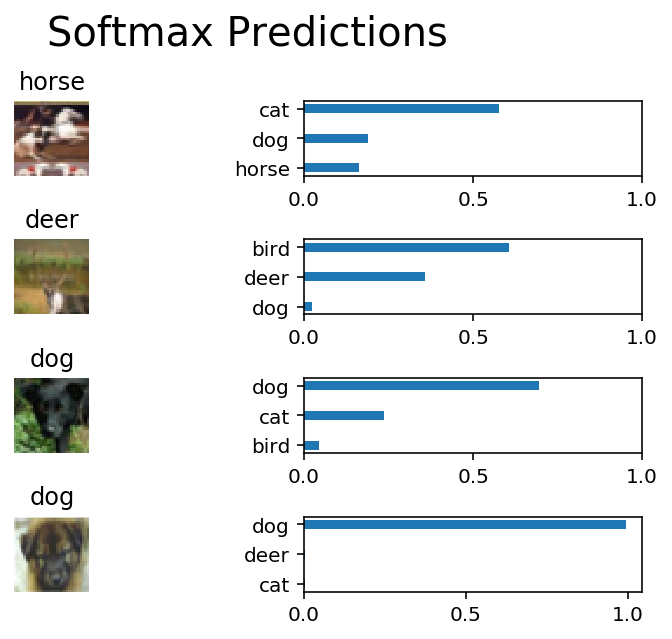

In [13]:
"""
请勿改动本单元内代码
"""
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

import tensorflow as tf
import pickle
import helper
import random


try:
    if batch_size:
        pass
except NameError:
    batch_size = 64

save_model_path = './image_classification'
n_samples = 4
top_n_predictions = 3

def test_model():

    test_features, test_labels = pickle.load(open('preprocess_test.p', mode='rb'))
    loaded_graph = tf.Graph()

    with tf.Session(graph=loaded_graph) as sess:
        # 读取模型
        loader = tf.train.import_meta_graph(save_model_path + '.meta')
        loader.restore(sess, save_model_path)

        # 从已经读入的模型中 获取tensors 
        loaded_x = loaded_graph.get_tensor_by_name('inputs:0')
        loaded_y = loaded_graph.get_tensor_by_name('labels:0')
        loaded_logits = loaded_graph.get_tensor_by_name('logits:0')
        loaded_acc = loaded_graph.get_tensor_by_name('accuracy:0')
        
        # 获取每个batch的准确率，再求平均值，这样可以节约内存
        test_batch_acc_total = 0
        test_batch_count = 0
        
        for test_feature_batch, test_label_batch in helper.batch_features_labels(test_features, test_labels, batch_size):
            test_batch_acc_total += sess.run(
                loaded_acc,
                feed_dict={loaded_x: test_feature_batch, loaded_y: test_label_batch})
            test_batch_count += 1

        print('Testing Accuracy: {}\n'.format(test_batch_acc_total/test_batch_count))

        # 随机打印一个例子
        random_test_features, random_test_labels = tuple(zip(*random.sample(list(zip(test_features, test_labels)), n_samples)))
        random_test_predictions = sess.run(
            tf.nn.top_k(tf.nn.softmax(loaded_logits), top_n_predictions),
            feed_dict={loaded_x: random_test_features, loaded_y: random_test_labels})
        helper.display_image_predictions(random_test_features, random_test_labels, random_test_predictions)


test_model()